In [1]:
from groundingdino.util.inference import load_model, load_image, predict, annotate
import groundingdino.datasets.transforms as T
import numpy as np
from PIL import Image
import os


In [2]:
root ="/home/vaschetti/maxarSrc/creating_labels/models"
CONFIG_PATH = os.path.join(root, "GDINO/GroundingDINO_SwinT_OGC.py")
print(CONFIG_PATH, "; exist:", os.path.isfile(CONFIG_PATH))
WEIGHTS_PATH = os.path.join(root, "GDINO/groundingdino_swint_ogc.pth")
print(WEIGHTS_PATH, "; exist:", os.path.isfile(WEIGHTS_PATH))
IMAGE_PATH = "/home/vaschetti/maxarSrc/exampleData/maxarSample.png"


/home/vaschetti/maxarSrc/creating_labels/models/GDINO/GroundingDINO_SwinT_OGC.py ; exist: True
/home/vaschetti/maxarSrc/creating_labels/models/GDINO/groundingdino_swint_ogc.pth ; exist: True


In [4]:
im = Image.open(IMAGE_PATH).convert("RGB")
np_img_rgb = np.asarray(im)[:600,:600]

In [5]:
model = load_model(CONFIG_PATH, WEIGHTS_PATH)

def custom_img_load(np_img_rgb: np.array):
    transform = T.Compose(
        [
            T.RandomResize([800], max_size=1333),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    image_pillow = Image.fromarray(np_img_rgb)
    image_transformed, _ = transform(image_pillow, None)
    return image_transformed

/home/vaschetti/.pyenv/versions/3.10.13/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


In [6]:
image_transformed = custom_img_load(np_img_rgb)

In [49]:
TEXT_PROMPT = 'tree' #'house' #'tree'
BOX_TRESHOLD = 0.15
TEXT_TRESHOLD = 0.30
boxes, logits, phrases = predict(model, image_transformed, TEXT_PROMPT, BOX_TRESHOLD, TEXT_TRESHOLD)
#Note: boxes are in the format cxcywh (centre, width and height, cx, cy being center of box, w, h being width and height.)

/home/vaschetti/.pyenv/versions/3.10.13/lib/python3.10/site-packages/transformers/modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/vaschetti/.pyenv/versions/3.10.13/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/vaschetti/.pyenv/versions/3.10.13/lib/python3.10/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


In [50]:
def filter_on_box_area_mt2(boxes, np_img, img_res, min_area_mt2 = 0, max_area_mt2 = 24):
    """
    Filter boxes based on min and max area.
    Inputs:
        boxes: torch.Tensor of shape (N, 4). Where boxes are in the format cxcywh (the output of GroundingDINO).
        np_img: np.array of shape (H, W, 3)
        img_res: float, the resolution of the image (mt/pxl).
        min_area_mt2: float
        max_area_mt2: float
    Output:
        keep_ix: torch.Tensor of shape (N,)
    """
    h, w, _ = np_img.shape
    tmp_boxes = boxes.clone()
    tmp_boxes = tmp_boxes * torch.Tensor([w, h, w, h])

    area_mt2 = torch.prod(tmp_boxes[:,2:], dim=1) * img_res**2
    keep_ix = (area_mt2 > min_area_mt2) & (area_mt2 < max_area_mt2)
    
    return keep_ix

In [51]:
h, w, _ = np_img_rgb.shape
img_res = 0.30517578125
tmp_boxes = boxes.clone()
print(tmp_boxes.shape)
tmp_boxes = tmp_boxes * torch.Tensor([w, h, w, h])

area_mt2 = torch.prod(tmp_boxes[:,:2], dim=1) * img_res**2
print(area_mt2.shape)

torch.Size([133, 4])
torch.Size([133])


In [52]:
import matplotlib.pyplot as plt
from torchvision.ops import box_convert

def plotDinoBoxes(np_img_rgb, boxes):
    fig, ax = plt.subplots()
    ax.imshow(np_img_rgb)

    h, w, _ = np_img_rgb.shape
    tmp_boxes = boxes.clone()
    tmp_boxes = tmp_boxes * torch.Tensor([w, h, w, h])
    xyxy = box_convert(boxes=tmp_boxes, in_fmt="cxcywh", out_fmt="xyxy").numpy()
    
    for box in xyxy:
        x1, y1, x2, y2 = box
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, color="red")
        ax.add_patch(rect)
    plt.show()

In [53]:
boxes.shape

torch.Size([133, 4])

In [54]:
#Stats on the boxes
img_res = 0.30517578125
h, w, _ = np_img_rgb.shape
tmp_boxes = boxes.clone()
tmp_boxes = tmp_boxes * torch.Tensor([w, h, w, h])

area_mt2 = torch.prod(tmp_boxes[:,2:], dim=1) * img_res**2

In [55]:
area_mt2_np = area_mt2.numpy()

In [56]:
area_mt2.max()

tensor(33527.5469)

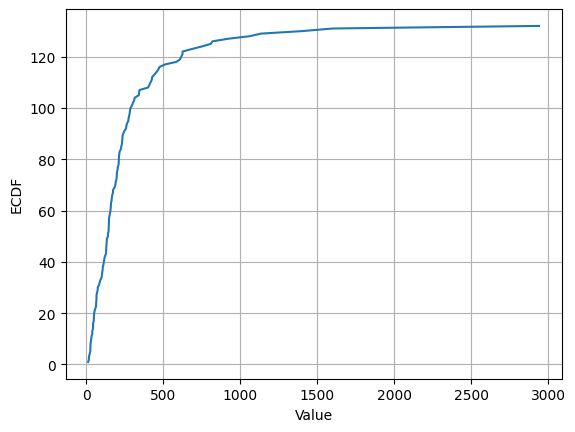

In [57]:
img_res = 0.30517578125
keep_ix = filter_on_box_area_mt2(boxes, np_img_rgb, img_res, min_area_mt2 = 0, max_area_mt2 = 6000) #360_000
#print(area_mt2_np[keep_ix])
array_sorted = np.sort(area_mt2_np[keep_ix])
cumulative_counts = np.arange(1, len(area_mt2_np[keep_ix]) + 1) #/ len(area_mt2_np)
plt.plot(array_sorted, cumulative_counts)
plt.xlabel('Value')
plt.ylabel('ECDF')
plt.grid(True)
plt.show()

torch.Size([132])


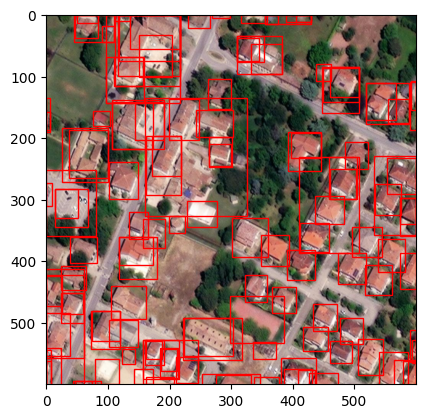

In [58]:
print(keep_ix[keep_ix].shape)
plotDinoBoxes(np_img_rgb, boxes[keep_ix])

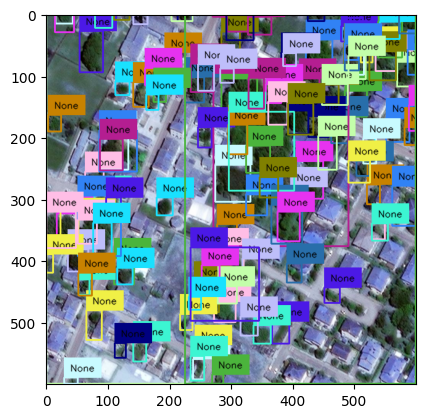

In [83]:
img_res = 0.30517578125
keep_ix = filter_on_box_area_mt2(boxes, np_img_rgb, img_res, max_area_mt2 = 20000) #360_000

import matplotlib.pyplot as plt
annotated_frame = annotate(image_source=np_img_rgb, boxes=boxes[keep_ix], logits=logits, phrases=phrases)
plt.imshow(annotated_frame)

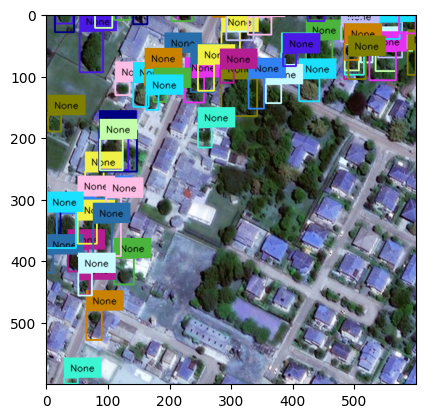

In [75]:
import matplotlib.pyplot as plt
annotated_frame = annotate(image_source=np_img_rgb, boxes=boxes[keep_ix], logits=logits, phrases=phrases)
plt.imshow(annotated_frame)

In [19]:
from torchvision.ops import box_convert
xyxy = box_convert(boxes=boxes, in_fmt="cxcywh", out_fmt="xyxy").numpy()


In [8]:
np_img_rgb.shape

(600, 600, 3)

In [9]:
from copy import deepcopy
sample_size = np_img_rgb.shape[0]
rel_boxes = deepcopy(boxes)*sample_size

In [10]:
import sys
sys.path.append('/home/vaschetti/maxarSrc/creating_labels/utils')
from plotting_utils import show_mask, show_Linestrings, show_points, show_box, plot_comparison

In [11]:
rel_boxes

tensor([[ 73.3683,  61.2112,  38.6267,  67.2924],
        [502.1826, 145.2166,  36.0983,  42.0895],
        [192.1733, 312.2039,  25.9150,  28.8499],
        [293.6236, 358.1839,  31.5931,  34.9959],
        [443.1907,  70.7007,  43.5496,  58.5635],
        [426.7860, 123.2312,  33.4677,  36.6629],
        [ 78.4213, 504.3079,  24.9548,  48.2354],
        [ 33.2075, 350.6690,  31.1242,  53.7530],
        [151.7283, 547.0699,  21.2246,  33.3658],
        [ 52.1600, 399.5814,  33.0632,  36.2674],
        [299.6598,  47.7151,  30.2985,  38.9487],
        [294.2979, 410.6233,  52.0392,  63.0741],
        [240.8559, 122.9601,  30.9786,  41.1255],
        [302.9520, 274.1408,  56.9419,  60.0728],
        [393.3008,  79.4351,  24.5337,  32.9355],
        [584.3189,  97.3978,  29.7070,  40.7042],
        [490.2679,  31.8482,  23.0711,  25.1289],
        [313.2881, 134.7170,  57.5881,  60.7254],
        [123.8134, 120.3846,  22.4158,  21.4338],
        [204.2626,  77.0720,  23.6281,  29.4756],


In [17]:
annotated_frame = annotate(image_source=np_img_rgb, boxes=boxes, logits=logits, phrases=phrases)

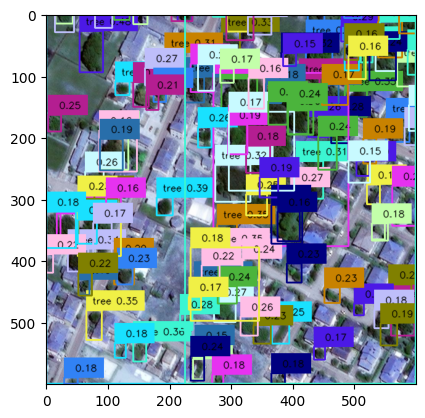

In [18]:
import matplotlib.pyplot as plt
annotated_frame = annotate(image_source=np_img_rgb, boxes=boxes, logits=logits, phrases=phrases)
plt.imshow(annotated_frame)

Il resto del codice sotto è inutile

In [8]:
TEXT_PROMPT = "tree"
BOX_TRESHOLD = 0.15
TEXT_TRESHOLD = 0.30

In [9]:
IMAGE_PATH = "/home/vaschetti/maxarSrc/exampleData/maxarSample.png"
image_source, image = load_image(IMAGE_PATH)

In [10]:
image_source, image = load_image(IMAGE_PATH)

boxes, logits, phrases = predict(
    model=model,
    image=image,
    caption=TEXT_PROMPT,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

NameError: name '_C' is not defined

In [ ]:
image = cv2.imread(IMAGE_PATH)
#
# GDModel.predict_with_caption(image)

In [ ]:
image.shape

(632, 714, 3)

In [ ]:
from groundingdino.util.inference import Model
import cv2
import os

root ="/home/vaschetti/maxarSrc/creating_labels/models"
CONFIG_PATH = os.path.join(root, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
print(CONFIG_PATH, "; exist:", os.path.isfile(CONFIG_PATH))
WEIGHTS_NAME = "groundingdino_swint_ogc.pth"
WEIGHTS_PATH = os.path.join(root, "GroundingDINO/weights", WEIGHTS_NAME)
print(WEIGHTS_PATH, "; exist:", os.path.isfile(WEIGHTS_PATH))
IMAGE_PATH = "/home/vaschetti/maxarSrc/exampleData/maxarSample.png"

/home/vaschetti/maxarSrc/creating_labels/models/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py ; exist: True
/home/vaschetti/maxarSrc/creating_labels/models/GroundingDINO/weights/groundingdino_swint_ogc.pth ; exist: True


In [ ]:
caption = 'trees'
BOX_THRESHOLD = 0.15
TEXT_THRESHOLD = 0.30

image = cv2.imread(IMAGE_PATH)

model = Model(model_config_path=CONFIG_PATH, model_checkpoint_path=WEIGHTS_PATH)

detections, labels = model.predict_with_caption(image=image,
                                                caption=caption,
                                                box_threshold=BOX_THRESHOLD,
                                                text_threshold=TEXT_THRESHOLD
                                            )

import supervision as sv

box_annotator = sv.BoxAnnotator()
annotated_image = box_annotator.annotate(scene=image, detections=detections, labels=labels)

final text_encoder_type: bert-base-uncased


/home/vaschetti/.pyenv/versions/3.10.13/lib/python3.10/site-packages/transformers/modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/vaschetti/.pyenv/versions/3.10.13/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/vaschetti/.pyenv/versions/3.10.13/lib/python3.10/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


In [ ]:
labels

['trees',
 'trees',
 'trees',
 'trees',
 'trees',
 'trees',
 'trees',
 'trees',
 'trees',
 'trees',
 'trees',
 'trees',
 'trees',
 'trees',
 'trees',
 'trees',
 'trees',
 'trees',
 'trees',
 'trees',
 'trees',
 'trees',
 'trees',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'trees',
 '',
 '',
 '',
 '',
 '',
 'trees',
 '',
 '',
 '',
 'trees',
 '',
 '',
 'trees',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '']

In [ ]:
Model.preprocess_image(image_bgr=image)

tensor([[[ 1.4783,  1.4783,  1.4783,  ...,  0.7933,  0.7933,  0.7933],
         [ 1.4783,  1.4783,  1.4783,  ...,  0.7933,  0.7933,  0.7933],
         [ 1.4783,  1.4783,  0.9988,  ...,  0.2624,  0.7933,  0.7933],
         ...,
         [ 1.4783,  1.4783,  1.4269,  ...,  0.2967,  0.7933,  0.7933],
         [ 1.4783,  1.4783,  1.4783,  ...,  0.7933,  0.7933,  0.7933],
         [ 1.4783,  1.4783,  1.4783,  ...,  0.7933,  0.7933,  0.7933]],

        [[ 2.2535,  2.2535,  2.2535,  ...,  2.4286,  2.4286,  2.4286],
         [ 2.2535,  2.2535,  2.2535,  ...,  2.4286,  2.4286,  2.4286],
         [ 2.2535,  2.2535,  1.6583,  ...,  1.5882,  2.4286,  2.4286],
         ...,
         [ 2.2535,  2.2535,  1.9734,  ...,  1.6758,  2.4286,  2.4286],
         [ 2.2535,  2.2535,  2.2535,  ...,  2.4286,  2.4286,  2.4286],
         [ 2.2535,  2.2535,  2.2535,  ...,  2.4286,  2.4286,  2.4286]],

        [[-0.7587, -0.7587, -0.7587,  ...,  1.5942,  1.5942,  1.5942],
         [-0.7587, -0.7587, -0.7587,  ...,  1

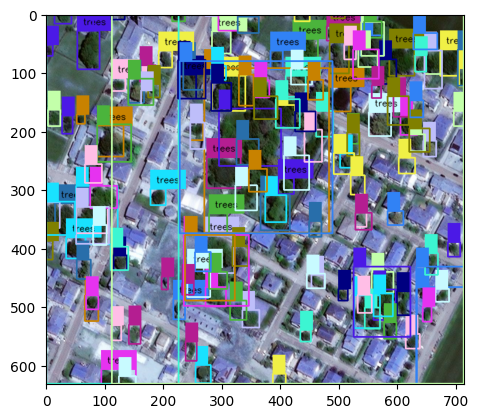

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(image)

In [ ]:
annotated_image.shape

(632, 714, 3)